# Recommending Amazon Products using Graph Neural Networks in PyTorch Geometric

- Read README.MD to install the dependencies.

Based on https://wandb.ai/manan-goel/gnn-recommender/reports/Recommending-Amazon-Products-using-Graph-Neural-Networks-in-PyTorch-Geometric--VmlldzozMTA3MzYw

In [1]:
from tqdm import tqdm
import numpy as np
from IPython.display import IFrame
import os

import torch
from torch import nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric import utils
from torch_geometric.transforms import RandomLinkSplit
import torch_geometric as pyg

from pyvis.network import Network

In [2]:
from model import GNN

In [3]:
from torch_geometric.explain import Explainer, GNNExplainer

## Data
Load the datasets (train, test and validation0 from disk)

In [4]:
# Save the splits and save as W&B artifacts
train_graph = torch.load('train.pt')
val_graph = torch.load('val.pt')
test_graph = torch.load('test.pt')

## Model

In [5]:
# This notebook uses the pre-trained model
# -> generated by `Recommending Amazon Products-Model.ipynb`

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0

#epochs = 300
epochs = 3

hidden_dim = 1024
dropout = 0.3
num_layers = 2
lr = 1e-5
node_emb_dim = 2  # 2 features: in/out-degrees
batch_size = 1024

In [7]:
model_name = "gnn.pt"

model = GNN(
    node_emb_dim, 
    hidden_dim, 
    hidden_dim, 
    num_layers, 
    dropout
).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate

# skip training if it is trained
model.load_state_dict(torch.load(model_name))
model.eval()

GNN(
  (convs): ModuleList(
    (0): SAGEConv(2, 1024, aggr=mean)
    (1): SAGEConv(1024, 1024, aggr=mean)
  )
  (post_mp): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
)

In [8]:
train_graph = train_graph.to(device)
val_graph = val_graph.to(device)

## Explain model using GNNExplainer

### you must control below the number of epochs used to train the explainer!

In [9]:
epochs_explainer = 10

In [10]:
gnnexplainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=epochs_explainer),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

### select one node to test

In [11]:
node_index = 10
explanation = gnnexplainer(
    torch.tensor(test_graph.x).float().to(device), 
    test_graph.edge_index, 
    index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

Generated explanations in ['edge_mask', 'node_mask']


In [12]:
path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

Subgraph visualization plot has been saved to 'subgraph.pdf'


In [13]:
IFrame('subgraph.pdf', width=800, height=500)

In [14]:
test_graph.x.shape  # shape[1] ==>> number of features

(262111, 2)

In [15]:
# If there is only one feature, will raise
# ValueError: Cannot compute feature importance for object-level 'node_mask' (got shape torch.Size([262111, 1]))

In [16]:
path = 'feature_importance.png'
explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

Feature importance plot has been saved to 'feature_importance.png'


<img src="./feature_importance.png" alt="Computed feature importance" />

In [17]:
feat_graph_path = 'graph_feature_importance.png'
explanation.visualize_graph(feat_graph_path)

<img src="./graph_feature_importance.png" alt="Computed feature importance" />

### another node

In [18]:
node_index = 160
explanation2 = gnnexplainer(
    torch.tensor(test_graph.x).float().to(device), 
    test_graph.edge_index, 
    index=node_index)
print(f'Generated explanations in {explanation2.available_explanations}')

Generated explanations in ['edge_mask', 'node_mask']


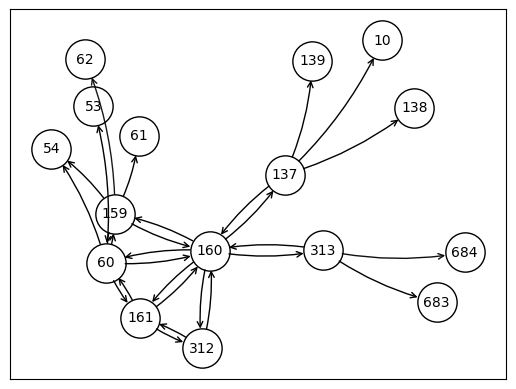

In [19]:
explanation2.visualize_graph()